## ANALISI DATI EEG con algoritmo di Sinkhorn e algoritmo FreeEnergy

autore: Miriam Zara, Università degli studi di Padova, ultima modifica 09/03/2024

necessario importare il file "my.sinkhorn.py", che contiene l'algoritmo di Sinkhorn, e il file "freeot.py", che contiene l'algoritmo free energy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats
import pandas as pd
import statsmodels as sm
from statsmodels.stats.anova import AnovaRM
import freeot
import mysinkhorn

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1569/2197354630.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


IMPUT: best_maps.csv ogni riga contiene le 64 coordinate di un centroide. i centroidi sono 9.

OUTPUT:  cost_sqeuclidean= np.array((9,9)). Le entrate sono normalizzate ad 1

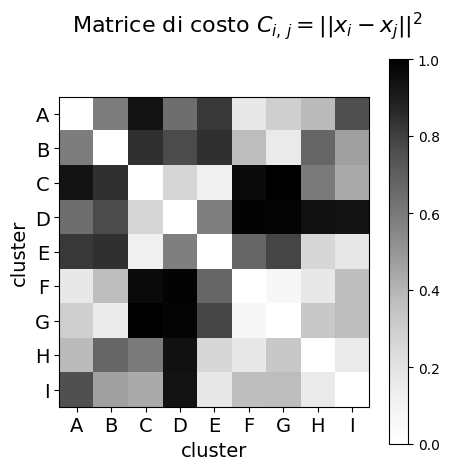

In [2]:
data= np.loadtxt('best_maps.csv', delimiter= ',')
centroidi=np.array(data)
n_cluster=centroidi.shape[0]
n_channels=centroidi.shape[1]
cost_euclidean=np.zeros((9,9))
cost_sqeuclidean=np.zeros((9,9))
for i in range(n_cluster):
    for j in range(n_cluster):
        cost_euclidean[i,j]=np.linalg.norm(centroidi[i]-centroidi[j])
        cost_sqeuclidean[i,j]=np.linalg.norm(centroidi[i]-centroidi[j])**2
cost_euclidean/=cost_euclidean.max()
cost_sqeuclidean/=cost_sqeuclidean.max()
fig, ax2 = plt.subplots(figsize = (5,5))
im2=ax2.imshow(cost_sqeuclidean, cmap='Greys')
positions=np.arange(9)
ax2.set_xlabel("cluster", fontsize=14)
ax2.set_ylabel("cluster", fontsize=14)
ax2.set_xticks(positions)
ax2.set_xticklabels(['A','B','C','D','E','F','G','H','I'], fontsize=14)
ax2.set_yticks(positions)
ax2.set_yticklabels(['A','B','C','D','E','F','G','H','I'], fontsize=14)

#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define position and size of the colorbar axis
cbar = fig.colorbar(im2)
plt.suptitle(r'Matrice di costo $C_{i,\,j}=||x_{i}-x_j||^{2}$', fontsize=16)
plt.savefig("EEG_matrice.svg")
plt.savefig("EEG_matrice.eps")

### Analisi con Sinkhorn

Imput: 'prob_states.csv', colonne= [Subject,Cond,Int,State,Prob]

Output: panda DataFrame 'results_df', colonne= ['Soggetto', 'C/I', 'PC', 'Costo']

In [3]:
dati_df=pd.read_csv('prob_states.csv')
n_soggetti=44
n_task=7
n_task_effettive=6
n_cluster=9
nomi_colonne_results=['Subject', 'Cond', 'Int', 'Cost' ]
results_df=pd.DataFrame(index=range(n_soggetti*6), columns=nomi_colonne_results)
lunghezza_blocco_soggetto=n_cluster*n_task
resting_temp=np.zeros(n_cluster)
task_temp=np.zeros(n_cluster)

epsilon = 0.01

for n in np.arange(n_soggetti):
    for k in np.arange(n_cluster):
            resting_temp[k]=dati_df['Prob'][(lunghezza_blocco_soggetto*n)+k]
    for m in np.arange(1, 7):
        for p in np.arange(n_cluster):
            task_temp[p]=dati_df['Prob'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)+p]
        #######################################################
        G_sinkhorn=mysinkhorn.sinkhorn_solver(resting_temp, task_temp, epsilon, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,G_sinkhorn)
        ######################################################
        costo=np.sum(matbis)
        results_df.loc[n*6+m-1, 'Subject']=n+1 
        results_df.loc[n*6+m-1,'Cond']=dati_df['Cond'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)] #condizione C /I
        results_df.loc[n*6+m-1,'Int' ]=dati_df['Int'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)] #int H,M,L
        results_df.loc[n*6+m-1,'Cost']=costo

print(results_df)

Maximum number of iterations reached (1000), convergence criterion NOT reached
Maximum number of iterations reached (1000), convergence criterion NOT reached
Maximum number of iterations reached (1000), convergence criterion NOT reached
    Subject Cond Int      Cost
0         1    C   H  0.025178
1         1    C   M   0.02208
2         1    C   L  0.023266
3         1    I   H  0.051705
4         1    I   M  0.043137
..      ...  ...  ..       ...
259      44    C   M  0.022259
260      44    C   L  0.020402
261      44    I   H  0.022364
262      44    I   M  0.019625
263      44    I   L  0.025793

[264 rows x 4 columns]


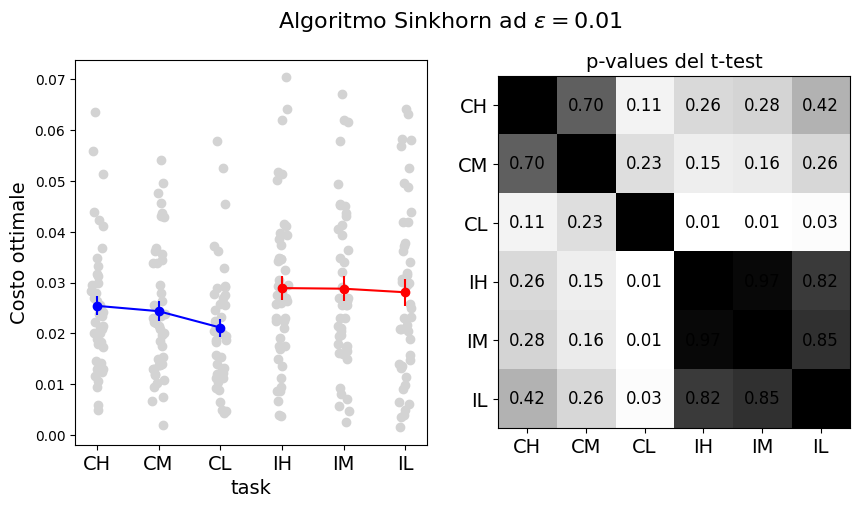

In [4]:
a_values = ['C', 'I']
b_values = ['H','M','L']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

counter = -1

medie = []
errore_medie = []

for a in a_values:
    for b in b_values:
        counter += 1
        prova = results_df[results_df['Cond']==a]
        prova = prova[prova['Int']==b]
        prova_cost=prova['Cost'].values
        media = prova_cost.mean(); medie += [media]
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie += [errore_media]
        ax1.scatter(np.random.uniform(counter-0.1, counter+0.1, prova_cost.size), prova_cost , color='lightgrey')


ax1.errorbar([0,1,2], [medie[0], medie[1], medie[2]], yerr= [errore_medie[0],errore_medie[1], errore_medie[2]], color='blue')
ax1.plot([0, 1, 2], [medie[0], medie[1], medie[2]], marker='o', markersize=6, color='blue', linestyle='None')
ax1.errorbar([3,4,5], [medie[3],medie[4], medie[5]], yerr= [errore_medie[3],errore_medie[4],errore_medie[5]], color='red')
ax1.plot([3, 4, 5], [medie[3], medie[4], medie[5]], marker='o', markersize=6, color='red', linestyle='None')

xpositions=np.arange(n_task-1)
ax1.set_xlabel("task", fontsize=14)
ax1.set_ylabel("Costo ottimale", fontsize=14)
ax1.set_xticks(xpositions)
ax1.set_xticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)

#################### test T di student #########################################
pvalues=np.zeros((n_task-1, n_task-1))
counter_rows = -1

for a in a_values:
    for b in b_values:
        counter_rows += 1
        counter_cols = -1
        for a_bis in a_values:
            for b_bis in b_values:
                counter_cols += 1
                prova1 = results_df[results_df['Cond']==a]
                prova1 = prova1[prova1['Int']==b]
                prova1_cost=np.array(prova1['Cost'].values)

                prova2 = results_df[results_df['Cond']==a_bis]
                prova2 = prova2[prova2['Int']==b_bis]
                prova2_cost=np.array(prova2['Cost'].values)


                ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
                pvalues[counter_rows,counter_cols]=ttest.pvalue

ax2.set_title("p-values del t-test", fontsize = 14)
im=ax2.imshow(pvalues, cmap='Grays')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax2.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)

# Show the plot  
plt.suptitle(fr"Algoritmo Sinkhorn ad $\epsilon= {epsilon}$", fontsize = 16)
plt.savefig(f"EEG_risultati_epsilon={epsilon}.svg")
plt.show()

TWO WAY ANOVA TEST

In [5]:

arm = AnovaRM(data=results_df, depvar='Cost', subject='Subject', within=['Cond','Int'])
arm = arm.fit()
print(arm.summary())

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
Cond      9.9233 1.0000 43.0000 0.0030
Int       1.5727 2.0000 86.0000 0.2134
Cond:Int  1.1263 2.0000 86.0000 0.3290



### Analisi con FreeEnergyOT

Imput: panda DataFrame 'dati_df'

Output: panda DataFrame 'results_free_df',  colonne= ['Soggetto', 'C/I', 'PC', 'Costo']

In [6]:
from freeot import FreeOT
free_instance = FreeOT()

results_free_df=pd.DataFrame(index=range(n_soggetti*6), columns=nomi_colonne_results)
lunghezza_blocco_soggetto=n_cluster*n_task
resting_temp=np.zeros(n_cluster)
task_temp=np.zeros(n_cluster)

temperatura_iniziale = 0.01
temperatura_finale = 0.001
beta = 1/temperatura_finale


for n in np.arange(n_soggetti):
    for k in np.arange(n_cluster):
            resting_temp[k]=dati_df['Prob'][(lunghezza_blocco_soggetto*n)+k]
    for m in np.arange(1, 7):
        for p in np.arange(n_cluster):
            task_temp[p]=dati_df['Prob'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)+p]
        #######################################################
        G_free, cost_free=free_instance.solve(resting_temp, task_temp, cost_sqeuclidean, temperatura_iniziale, temperatura_finale)
        #print(G_free)
        #matbis=np.multiply(cost_sqeuclidean,G_free)
        ######################################################
        #costo=np.sum(matbis)
        results_free_df.loc[n*6+m-1, 'Subject']=n+1 
        results_free_df.loc[n*6+m-1,'Cond']=dati_df['Cond'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)] #condizione C /I
        results_free_df.loc[n*6+m-1,'Int' ]=dati_df['Int'][(lunghezza_blocco_soggetto*n)+(n_cluster*m)] #int H,M,L
        results_free_df.loc[n*6+m-1,'Cost']=cost_free

 
                Beta             U               Err_row        Err_col  
             100.00000        0.35981            0.00014       0.00017
             316.22777        0.20539            0.00150       0.00150
            1000.00000        0.08994            0.00000       0.00000
 
                Beta             U               Err_row        Err_col  
             100.00000        0.35852            0.00015       0.00021
             316.22777        0.20268            0.00100       0.00101
            1000.00000        0.08644            0.00000       0.00000
 
                Beta             U               Err_row        Err_col  
             100.00000        0.35860            0.00016       0.00022
             316.22777        0.20079            0.00030       0.00030
            1000.00000        0.08470            0.00000       0.00000
 
                Beta             U               Err_row        Err_col  
             100.00000        0.36543            0.00019 

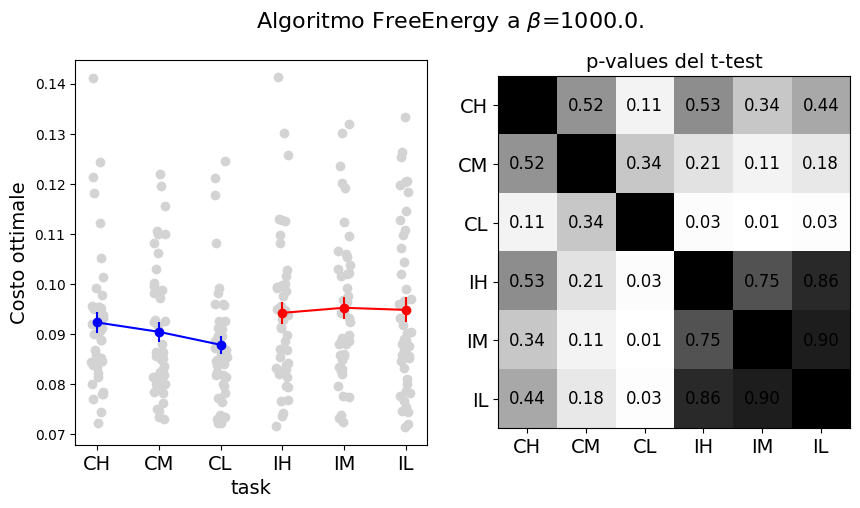

In [7]:
a_values = ['C', 'I']
b_values = ['H','M','L']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

counter = -1

medie = []
errore_medie = []

for a in a_values:
    for b in b_values:
        counter += 1
        prova = results_free_df[results_free_df['Cond']==a]
        prova = prova[prova['Int']==b]
        prova_cost=prova['Cost'].values
        media = prova_cost.mean(); medie += [media]
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie += [errore_media]
        ax1.scatter(np.random.uniform(counter-0.1, counter+0.1, prova_cost.size), prova_cost , color='lightgrey')


ax1.errorbar([0,1,2], [medie[0], medie[1], medie[2]], yerr= [errore_medie[0],errore_medie[1], errore_medie[2]], color='blue')
ax1.plot([0, 1, 2], [medie[0], medie[1], medie[2]], marker='o', markersize=6, color='blue', linestyle='None')
ax1.errorbar([3,4,5], [medie[3],medie[4], medie[5]], yerr= [errore_medie[3],errore_medie[4],errore_medie[5]], color='red')
ax1.plot([3, 4, 5], [medie[3], medie[4], medie[5]], marker='o', markersize=6, color='red', linestyle='None')

xpositions=np.arange(n_task-1)
ax1.set_xlabel("task", fontsize = 14)
ax1.set_ylabel("Costo ottimale", fontsize = 14)
ax1.set_xticks(xpositions)
ax1.set_xticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)

#################### test T di student #########################################
pvalues=np.zeros((n_task-1, n_task-1))
counter_rows = -1

for a in a_values:
    for b in b_values:
        counter_rows += 1
        counter_cols = -1
        for a_bis in a_values:
            for b_bis in b_values:
                counter_cols += 1
                prova1 = results_free_df[results_free_df['Cond']==a]
                prova1 = prova1[prova1['Int']==b]
                prova1_cost=np.array(prova1['Cost'].values)

                prova2 = results_free_df[results_free_df['Cond']==a_bis]
                prova2 = prova2[prova2['Int']==b_bis]
                prova2_cost=np.array(prova2['Cost'].values)


                ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
                pvalues[counter_rows,counter_cols]=ttest.pvalue

ax2.set_title("p-values del t-test", fontsize = 14)
im=ax2.imshow(pvalues, cmap='Grays')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(['CH','CM','CL','IH','IM','IL'], fontsize = 14)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax2.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)

# Show the plot  
plt.suptitle(fr"Algoritmo FreeEnergy a $\beta$={beta}.", fontsize = 16)
plt.savefig(f"EEG_risultati_beta={beta}.svg")
plt.show()

# PLOT delle OCCORRENZE

Imput: 'prob_states.csv', colonne= [Subject,Cond,Int,State,Prob]

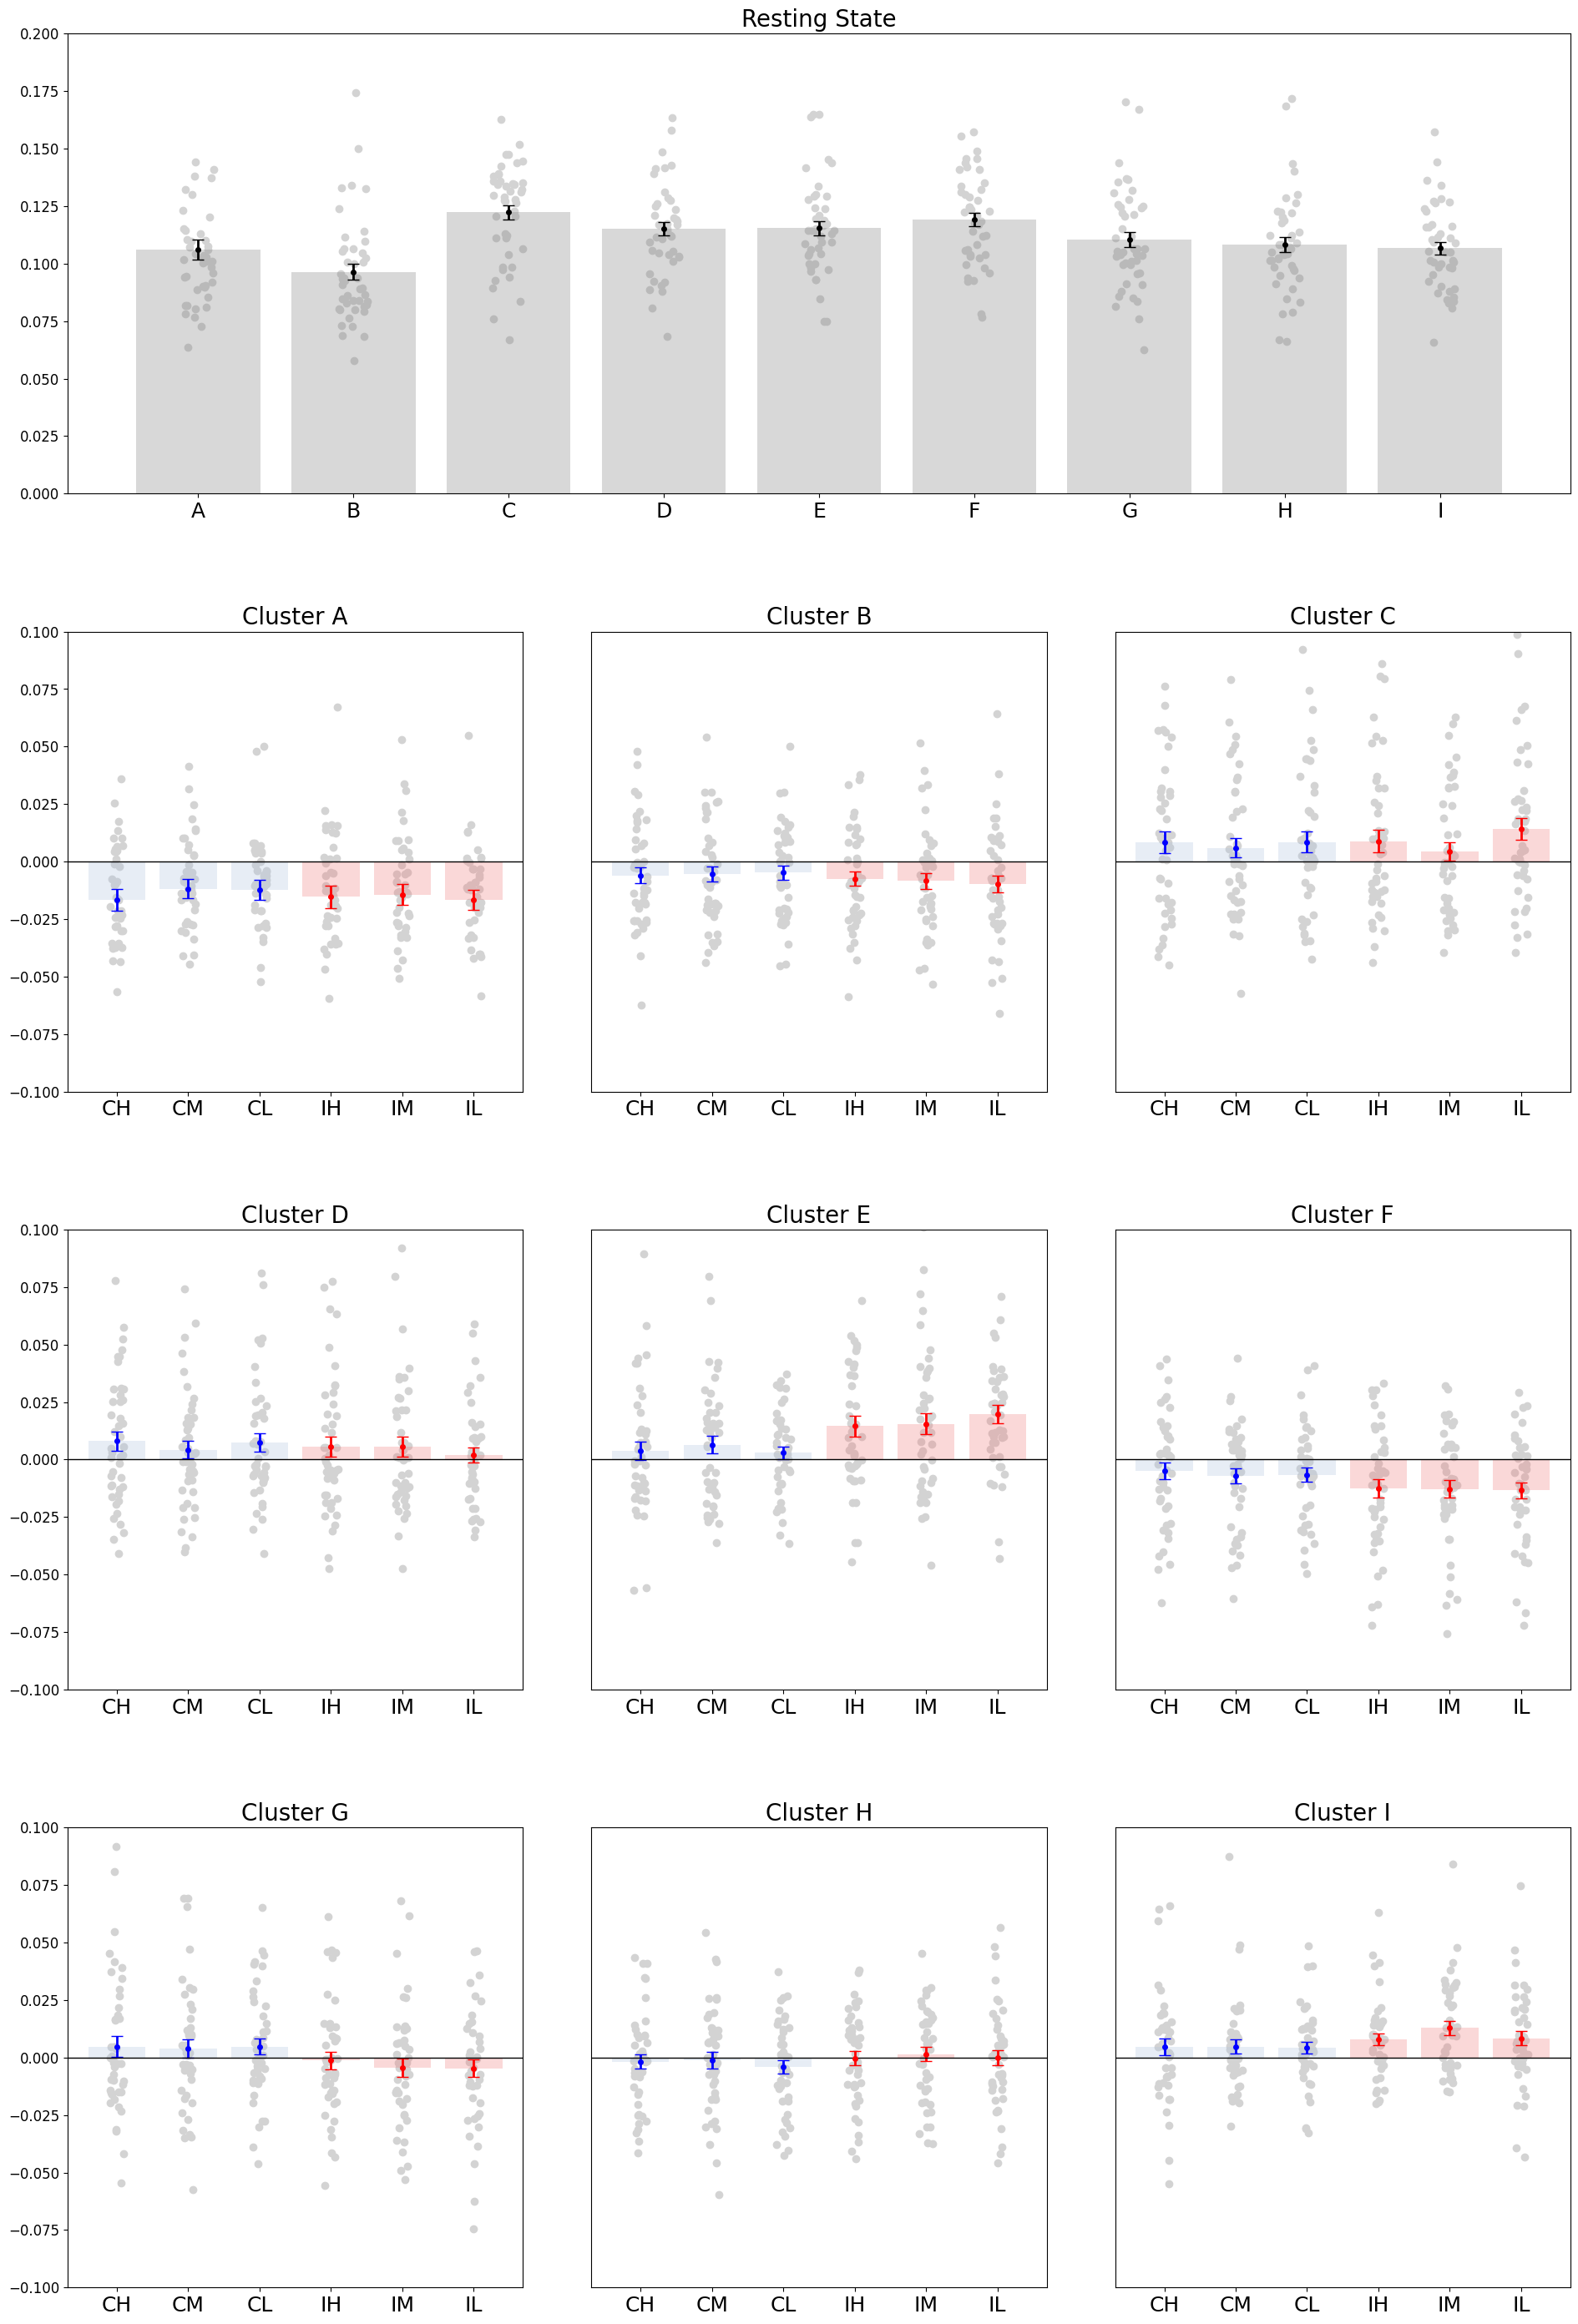

In [8]:
dati_df = pd.read_csv('prob_states.csv')
dati_resting_df = dati_df[dati_df['Cond']== 'R']

nomi_cluster = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
cond_values = ['C', 'I']
int_values = ['H','M','L']
fig = plt.figure(figsize=(20,30))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
gs=fig.add_gridspec(4,3, hspace=0.3, wspace=0.15)
ax0 = fig.add_subplot (gs [0, 0:])

medie = []
error = []
counter = -1
for a in nomi_cluster:
    counter += 1
    prova = dati_resting_df[dati_resting_df['State']==a]
    prova_cost=prova['Prob'].values
    media = prova_cost.mean(); medie += [media]
    errore_media = prova_cost.std()/np.sqrt(prova_cost.size); error += [errore_media]
    ax0.scatter(np.random.uniform(counter-0.1, counter+0.1, prova_cost.size), prova_cost , color='lightgrey')

ax0.errorbar(nomi_cluster, medie, yerr=error, marker='o', markersize=4, color='black', capsize=5, elinewidth=2, linestyle='None')
ax0.bar(nomi_cluster, medie, color= 'gray', alpha= 0.3)
ax0.set_xticks(range(len(nomi_cluster)))
ax0.set_xticklabels(nomi_cluster, fontsize=18)
ax0.set_ylim(0, 0.20)
ax0.tick_params(axis='y', labelsize=12)
ax0.set_title("Resting State", fontsize = 20)

####### riga 1 ###############
axes_counter = -1
for a in nomi_cluster[:3]:
    axes_counter += 1
    ax = fig.add_subplot (gs [1, axes_counter])
    temp_df = dati_df[dati_df['State'] == a]
    resting_temporaneo_df = dati_df[(dati_df['State'] == a) & (dati_df['Cond'] == 'R')]
    resting_temporaneo_values = resting_temporaneo_df['Prob'].values
    counter = -1
    medie = []
    error = []
    xvalues = []
    for c in cond_values:
        values_df = temp_df[temp_df['Cond'] == c]
        for i in int_values:
            counter += 1
            xvalues.append(c+i)
            values_fin_df = values_df[values_df['Int'] == i]
            values = values_fin_df['Prob'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')

    ax.errorbar(xvalues[:3], medie[:3], yerr=error[:3], marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[:3], medie[:3], color= 'lightsteelblue', alpha= 0.3)
    ax.errorbar(xvalues[3:], medie[3:], yerr=error[3:], marker='o', markersize=4, color='red', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[3:], medie[3:], color= 'lightcoral', alpha= 0.3)
    ax.set_xticks(range(len(xvalues)))
    ax.set_xticklabels(xvalues, fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {a}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(axes_counter != 0):
        ax.set_yticks([])

####### riga 2 ###############
axes_counter = -1
for a in nomi_cluster[3:6]:
    axes_counter += 1
    ax = fig.add_subplot (gs [2, axes_counter])
    temp_df = dati_df[dati_df['State'] == a]
    resting_temporaneo_df = dati_df[(dati_df['State'] == a) & (dati_df['Cond'] == 'R')]
    resting_temporaneo_values = resting_temporaneo_df['Prob'].values
    counter = -1
    medie = []
    error = []
    xvalues = []
    for c in cond_values:
        values_df = temp_df[temp_df['Cond'] == c]
        for i in int_values:
            counter += 1
            xvalues.append(c+i)
            values_fin_df = values_df[values_df['Int'] == i]
            values = values_fin_df['Prob'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')

    ax.errorbar(xvalues[:3], medie[:3], yerr=error[:3], marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[:3], medie[:3], color= 'lightsteelblue', alpha= 0.3)
    ax.errorbar(xvalues[3:], medie[3:], yerr=error[3:], marker='o', markersize=4, color='red', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[3:], medie[3:], color= 'lightcoral', alpha= 0.3)
    ax.set_xticks(range(len(xvalues)))
    ax.set_xticklabels(xvalues, fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {a}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(axes_counter != 0):
        ax.set_yticks([])

####### riga 3 ###############
axes_counter = -1
for a in nomi_cluster[6:9]:
    axes_counter += 1
    ax = fig.add_subplot (gs [3, axes_counter])
    temp_df = dati_df[dati_df['State'] == a]
    resting_temporaneo_df = dati_df[(dati_df['State'] == a) & (dati_df['Cond'] == 'R')]
    resting_temporaneo_values = resting_temporaneo_df['Prob'].values
    counter = -1
    medie = []
    error = []
    xvalues = []
    for c in cond_values:
        values_df = temp_df[temp_df['Cond'] == c]
        for i in int_values:
            counter += 1
            xvalues.append(c+i)
            values_fin_df = values_df[values_df['Int'] == i]
            values = values_fin_df['Prob'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')

    ax.errorbar(xvalues[:3], medie[:3], yerr=error[:3], marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[:3], medie[:3], color= 'lightsteelblue', alpha= 0.3)
    ax.errorbar(xvalues[3:], medie[3:], yerr=error[3:], marker='o', markersize=4, color='red', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(xvalues[3:], medie[3:], color= 'lightcoral', alpha= 0.3)
    ax.set_xticks(range(len(xvalues)))
    ax.set_xticklabels(xvalues, fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {a}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(axes_counter != 0):
        ax.set_yticks([])


#plt.suptitle(r"Occorrenze dei cluster nelle varie task, rispetto alle occorrenze al resting.", fontsize = 20,  y=0.95)
plt.savefig(f"EEG_cluster_occorrenze.pdf")

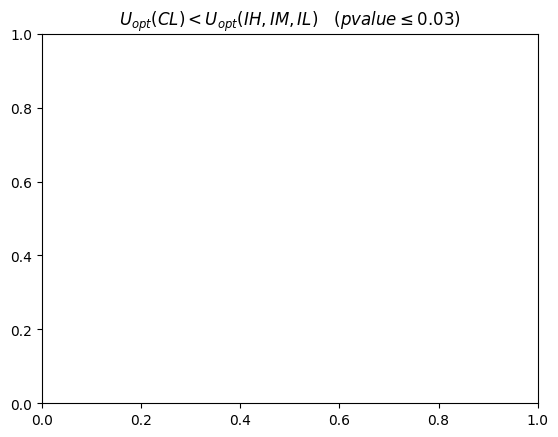

In [12]:
fig, ax = plt.subplots()

ax.set_title(r"$U_{opt}(CL)<U_{opt}(IH,IM,IL) \quad (pvalue \leq 0.03)$")
plt.savefig("testo.svg")